+ Motivated from the work of @dandxy89   https://github.com/dandxy89/DeepLearning_MachineLearning/tree/master/EmbeddingKeras    
and   
https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
 <br />

* **Train your own w2v model** on the dataset vocab  
* Use the **w2v vectors to initialise the weights of the embedding layer**  
* This is **2-stacked lstm**  (This is the only diff between this notebook and IMDB_Embedding_w2v_LSTM_1)
* This is **stateless lstm**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

In [2]:
import multiprocessing
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary

Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN 4004)


In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
np.random.seed(1337)  # For Reproducibility

from itertools import chain
from time import time

Using Theano backend.
/home/ubuntu/.virtualenvs/keras_0_3_2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
'''
data_locations = {'./Data/TRAIN_NEG.txt': 'TRAIN_NEG',
                  './Data/TRAIN_POS.txt': 'TRAIN_POS',
                  './Data/TEST_NEG.txt': 'TEST_NEG',
                  './Data/TEST_POS.txt': 'TEST_POS'}
'''

data_locations = {'./Data/test-neg.txt': 'TEST_NEG',
                  './Data/test-pos.txt': 'TEST_POS',
                  './Data/train-neg.txt': 'TRAIN_NEG',
                  './Data/train-pos.txt': 'TRAIN_POS'}

In [5]:
def import_tag(datasets=None):
    ''' Imports the datasets into one of two dictionaries

        Dicts:
            train & test

        Keys:
            values >= 4  are "Positive" in both Dictionaries

        '''
    if datasets is not None:
        train = {}
        test = {}
        for k, v in datasets.items(): #gives a list of tuples to iterate
            with open(k) as fpath:
                data = fpath.readlines()
            for val, each_line in enumerate(data):
                if v.endswith("NEG") and v.startswith("TRAIN"):
                    train[val] = each_line
                elif v.endswith("POS") and v.startswith("TRAIN"):
                    train[val + 12500] = each_line
                elif v.endswith("NEG") and v.startswith("TEST"):
                    test[val] = each_line
                else:
                    test[val + 12500] = each_line
        return train, test
    else:
        print('Data not found...')

In [6]:
train, test = import_tag(data_locations)

In [7]:
def tokenizer(text):
    ''' Simple Parser converting each document to lower-case, then
        removing the breaks for new lines and finally splitting on the
        whitespace
    '''
    text = [document.lower().replace('\n', '').split() for document in text]
    return text

In [8]:
print('Loading Data...')
combined = train.values() + test.values()
print('Tokenising...')
combined = tokenizer(combined)
#combined


Loading Data...
Tokenising...


In [9]:
# here we are training our own w2v model. we can as well use a pretrained model

# Word2Vec model parameters
vocab_dim = 300
n_exposures = 30 
window_size = 7 
n_iterations = 1  # ideally more..
cpu_count = multiprocessing.cpu_count() # number of workers

print('Training a Word2vec model...')
w2v_model = Word2Vec(size=vocab_dim,
                 min_count=n_exposures,
                 window=window_size,
                 workers=cpu_count,
                 iter=n_iterations)
w2v_model.build_vocab(combined)
w2v_model.train(combined)
print('Word2vec model trained...')
# --- by now a model should be ready

Training a Word2vec model...
Word2vec model trained...


In [10]:
#  get the vocab size of w2v_model
len(w2v_model.vocab.keys())

# this is one way to create dataset vocab
flat_list = chain(*combined)
dataset_vocab = set(flat_list)
len(dataset_vocab)
dataset_vocab_lower = [key.lower() for key in dataset_vocab]
       
#counter = 0
#for key in dataset_vocab_lower:
    

In [11]:
DIMENSION = 300
zero_vector = np.zeros(DIMENSION)

our_dict = {}
missing_count = 0

for key in dataset_vocab_lower:
    if key in w2v_model:
        our_dict[key] = w2v_model[key]
    else:
        missing_count += 1
        #print("missing key %s" %(key)) 
        our_dict[key] = zero_vector

print len(dataset_vocab_lower)
print missing_count

100673
85306


In [12]:
# process the dataset - all that needs to be done is: replace every word in dataset by its id = (token_id + 1)
# for token_id, refer to create_dictionaries()
def parse_dataset(data, w2indx):
    ''' 
        Transforms the Training and Testing Dictionaries - Words become integers. This converts each sentence into
        a bunch of integers just like imdb dataset in keras.
        Input: Data (dictionary) and w2indx (dictionary)
    '''
    for key in data.keys():
        txt = data[key].lower().replace('\n', '').split()
        new_txt = []
        for word in txt:
            try:
                new_txt.append(w2indx[word])
            except:
                new_txt.append(0)
        data[key] = new_txt
    return data

In [13]:
def create_dictionaries(train=None,
                        test=None,
                        model=None):
    ''' Function does are number of Jobs:
        1- Creates a word to index mapping
        2- Creates a word to vector mapping
    '''
    if (train is not None) and (model is not None) and (test is not None):
        gensim_dict = Dictionary() # initialise empty gensim.corpora.dictionary
        gensim_dict.doc2bow(w2v_model.vocab.keys(), 
                            allow_update=True)  # Converts words in model.vocab into the bag-of-words 
                                                # format = list of (token_id, token_frequency_count) 2-tuples
                                                # token_id is a running integer counter 
        
        w2indx = {v: k+1 for k, v in gensim_dict.items()} # create a dictionary with {word: (token_id + 1)}
        # [+1 is keep 0 reserved for no word in w2c model]
        
        w2vec = {word: model[word] for word in w2indx.keys()} #create a dictionary with {word: word_vector}
        
        #train = parse_dataset(train, w2indx)
        #test = parse_dataset(test, w2indx)
        return w2indx, w2vec
    else:
        print('No data provided...')

In [14]:
print('Transform the Data...')
index_dict, word_vectors = create_dictionaries(train=train, test=test, model=our_dict)
train = parse_dataset(train, index_dict)
test = parse_dataset(test, index_dict)

Transform the Data...


In [15]:
print('Setting up Arrays for Keras Embedding Layer...')
n_symbols = len(index_dict) + 1  # adding 1 to account for 0th index
embedding_weights = np.zeros((n_symbols + 1, vocab_dim))

for word, index in index_dict.items():
    embedding_weights[index, :] = word_vectors[word]

Setting up Arrays for Keras Embedding Layer...


In [16]:
print('Creating Datesets...')
X_train = train.values()
y_train = [1 if value > 12500 else 0 for value in train.keys()]
X_test = test.values()
y_test = [1 if value > 12500 else 0 for value in test.keys()]

Creating Datesets...


In [17]:
# data parameters
maxlen = 100

In [18]:
print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Convert labels to Numpy Sets...')
y_train = np.array(y_train)
y_test = np.array(y_test)

Pad sequences (samples x time)
('X_train shape:', (25000, 100))
('X_test shape:', (25000, 100))
Convert labels to Numpy Sets...


In [19]:
#Embedding layer parameter
input_length = 100

# training parameters
batch_size = 32
n_epoch = 5

In [20]:
print('Defining a Simple Keras Model...')
dl_model = Sequential()  # or Graph or whatever
dl_model.add(Embedding(output_dim=vocab_dim,
                    input_dim=n_symbols + 1,
                    mask_zero=True,
                    weights=[embedding_weights],
                    input_length=input_length))  # Adding Input Length

# A LSTM unit takes as input a sequence, but by default it doesn't return a sequence. To stack them, 
#you have to configure intermediate LSTM units to return sequences, using the constructor argument 
#"return_sequences=True"

dl_model.add(LSTM(512, return_sequences=True))  # returns a sequence of vectors of dimension 512
dl_model.add(Dropout(0.3))
dl_model.add(LSTM(512, return_sequences=True)) # returns a sequence of vectors of dimension 512
dl_model.add(Dropout(0.3))
dl_model.add(LSTM(512, return_sequences=False)) # return a single vector of dimension 512
dl_model.add(Dropout(0.3))
dl_model.add(Dense(1, activation='sigmoid'))

print('Compiling the Model...')
dl_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              class_mode='binary')
print('Model Compiled')

Defining a Simple Keras Model...
Compiling the Model...
Model Compiled


In [21]:
print("Train...")
start_time = time()
hist = dl_model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=n_epoch,
          verbose=2, validation_data=(X_test, y_test), show_accuracy=True)
end_time = time()

print("Training took %f secs" %(end_time - start_time))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
707s - loss: 0.5670 - acc: 0.6912 - val_loss: 0.4096 - val_acc: 0.8060
Epoch 2/5
706s - loss: 0.3121 - acc: 0.8707 - val_loss: 0.3335 - val_acc: 0.8557
Epoch 3/5
707s - loss: 0.2083 - acc: 0.9225 - val_loss: 0.3918 - val_acc: 0.8475
Epoch 4/5
706s - loss: 0.1389 - acc: 0.9531 - val_loss: 0.4046 - val_acc: 0.8459
Epoch 5/5
705s - loss: 0.0818 - acc: 0.9755 - val_loss: 0.5511 - val_acc: 0.8452
Training took 3533.030492 secs


In [22]:
print("Evaluate...")
loss, acc = dl_model.evaluate(X_test, y_test,
                            batch_size=batch_size,
                            show_accuracy=True)
print('Test score:', loss)
print('Test accuracy:', acc)

Evaluate...
25000/25000 [==============================] - 161s   
('Test score:', 0.55105100328207013)
('Test accuracy:', 0.84523999999999999)


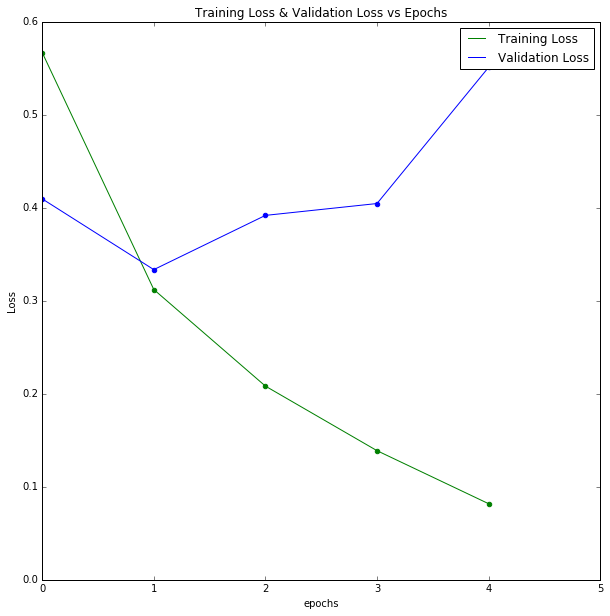

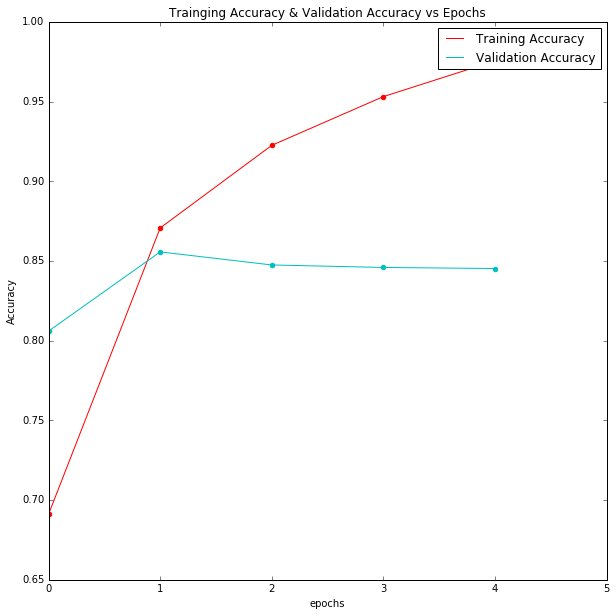

In [23]:
plt.figure(1)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['loss'], color='g')
plt.plot(hist.history['loss'], color='g', label='Training Loss')
plt.scatter(hist.epoch, hist.history['val_loss'], color='b')
plt.plot(hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss vs Epochs')
plt.legend()

plt.figure(2)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['acc'], color='r')
plt.plot(hist.history['acc'], color='r', label='Training Accuracy')
plt.scatter(hist.epoch, hist.history['val_acc'], color='c')
plt.plot(hist.history['val_acc'], color='c', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Trainging Accuracy & Validation Accuracy vs Epochs')
plt.legend()

plt.show()